### Introdução:

Futebol é um esporte popular no Brasil, que movimenta grandes transações financeiras e altera os ânimos até dos torcedores menos fanáticos.

De acordo com estudo realizado pelo Globo Esporte [1], um treinador permanece apenas cerca de seis meses no comando de uma equipe na elite do futebol brasileiro. As motivações principais para a mudança de técnico seriam a sequência de resultados negativos e as eliminações em demais campeonatos. Percebeu-se que os meses com mais trocas coincidiram com o fim de algumas competições, como Estaduais e Brasileiro. 

Dessa maneira, o principal objetivo deste trabalho é avaliar como o time reage à troca de técnico durante o campeonato brasileiro, e qual a relação desta mudança com a sequência de derrotas nessa competição.

Para tanto, foi utilizado um dataset do Cartola F.C., disponibilizado por Henrique Gomide em seu github [2]. Foram analisados dados referentes aos anos 2014 a 2017.

[1] https://interativos.globoesporte.globo.com/futebol/especial/rotatividade-dos-tecnicos

[2] https://github.com/henriquepgomide/caRtola/tree/master/data

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

O dataset que reúne informações sobre o Cartola F.C. entre 2014 e 2017 já possui uma limpeza prévia. Foi feita uma análise referente a esses dados:

In [136]:
df = pd.read_csv('dados_agregados_limpos.csv') #abrindo os dados raw para limpá-los de outra forma, mantendo os dados 
                                             #de técnicos

In [137]:
print(df.shape)
df.head(10)

(43821, 77)


,AtletaID,Rodada,ClubeID,Participou,Posicao,Jogos,Pontos,PontosMedia,Preco,PrecoVariacao,...,risk_points,mes,dia,home.score.x,away.score.x,pred.home.score,pred.away.score,home.attack,home.defend,variable
0,36443,1,285.0,True,gol,1.0,5.0,5.00,10.60,1.60,...,1.000000,4.0,19.0,1.0,0.0,NaN,NaN,NaN,NaN,home.team
1,36443,2,285.0,True,gol,2.0,-3.0,1.00,8.27,-2.33,...,1.000000,4.0,27.0,2.0,2.0,NaN,NaN,NaN,NaN,away.team
2,36443,3,285.0,True,gol,3.0,-2.6,-0.20,6.81,-1.46,...,1.000000,5.0,4.0,2.0,1.0,NaN,NaN,NaN,NaN,home.team
3,36443,4,285.0,True,gol,4.0,4.0,0.85,7.96,1.15,...,1.000000,5.0,10.0,2.0,1.0,NaN,NaN,NaN,NaN,home.team
4,36443,5,285.0,True,gol,5.0,5.0,1.68,8.61,0.65,...,1.000000,5.0,18.0,0.0,0.0,NaN,NaN,NaN,NaN,away.team
5,36443,6,285.0,True,gol,6.0,1.2,1.60,8.02,-0.59,...,1.000000,5.0,21.0,1.0,1.0,NaN,NaN,NaN,NaN,away.team
6,36443,7,285.0,True,gol,7.0,-3.3,0.90,6.75,-1.27,...,1.000000,5.0,25.0,1.0,3.0,NaN,NaN,NaN,NaN,home.team
7,36443,8,285.0,True,gol,8.0,3.0,1.16,7.55,0.80,...,1.000000,5.0,28.0,2.0,0.0,NaN,NaN,NaN,NaN,home.team
8,36443,9,285.0,True,gol,9.0,-1.5,0.86,6.71,-0.84,...,3.320910,6.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,away.team
9,36443,10,285.0,True,gol,10.0,-4.0,0.37,6.01,-0.70,...,3.649901,7.0,17.0,2.0,1.0,NaN,NaN,NaN,NaN,away.team


In [138]:
df['Posicao'].value_counts() #checando: esse dataframe contém as informações de técnicos

mei    12107
ata     7759
lat     5428
zag     5008
gol     2743
tec     2293
Name: Posicao, dtype: int64

Foi utilizado o mesmo código para limpeza de dataset, modificando apenas a linha em que o provedor remove os dados dos técnicos.

In [139]:
#utilizando o código da limpeza original, feita pelo provedor do dataset
cols_scouts_def = ['CA','CV','DD','DP','FC','GC','GS','RB','SG'] # alphabetical order
cols_scouts_atk = ['A','FD','FF','FS','FT','G','I','PE','PP'] # alphabetical order
cols_scouts = cols_scouts_def + cols_scouts_atk

scouts_weights = np.array([-2.0, -5.0, 3.0, 7.0, -0.5, -6.0, -2.0, 1.7, 5.0, 5.0, 1.0, 0.7, 0.5, 3.5, 8.0, -0.5, -0.3, -3.5])

ROUND_TO_PREDICT = 38

In [140]:
print("Dimensões originais dos dados: ", df.shape)

# remove todas as linhas cujo scouts são NANs 
df_clean = df.dropna(how='all', subset=cols_scouts)
print('qtde. de jogadores com scouts: ', df_clean.shape[0])

# remove todas as linhas com rodada == 0
df_clean = df_clean[df_clean['Rodada'] > 0]
print("qtde. de linhas após eliminação da rodada 0: ", df_clean.shape[0])

# remove todos os jogadores que não participaram de alguma rodada
df_clean = df_clean[(df_clean['Participou'] == True) | (df_clean['PrecoVariacao'] != 0)]
print("qtde. de linhas com jogadores que participaram de alguma rodada: ", df_clean.shape[0])

# altera os Status = NAN para 'Provável'
df_clean.loc[df_clean.Status.isnull(), 'Status'] = 'Provável'

# atualiza nomes dos jogadores sem ids e remove jogadores sem nome
df_ids =  df.groupby('AtletaID')['Apelido'].unique()
dict_ids = dict(zip(df_ids.index, [str(v[-1]) for v in df_ids.values]))
dict_ids = {k:v for k,v in dict_ids.items() if v != 'nan'}
df_clean['Apelido'] = df_clean['AtletaID'].map(dict_ids)
df_clean = df_clean[~df_clean['Apelido'].isnull()]
print("qtde. de jogadores com nome: ", df_clean.shape[0])

# remove jogadores sem posição 
# modificação!! > não foi removido a posição 'técnico'
df_clean = df_clean[(~df_clean['Posicao'].isnull())]

print("qtde. de linhas com posições válidas: ", df_clean.shape[0])

# preenche NANs restantes com zeros (verificado antes!)
df_clean.fillna(value=0, inplace=True)

print("Dimensão dos dados após as limpezas: ", df_clean.shape)
df_clean.head(10)

Dimensões originais dos dados:  (43821, 77)
qtde. de jogadores com scouts:  43821
qtde. de linhas após eliminação da rodada 0:  43821
qtde. de linhas com jogadores que participaram de alguma rodada:  43821
qtde. de jogadores com nome:  29118
qtde. de linhas com posições válidas:  24545
Dimensão dos dados após as limpezas:  (24545, 77)


,AtletaID,Rodada,ClubeID,Participou,Posicao,Jogos,Pontos,PontosMedia,Preco,PrecoVariacao,...,risk_points,mes,dia,home.score.x,away.score.x,pred.home.score,pred.away.score,home.attack,home.defend,variable
53,36540,1,285.0,True,zag,1.0,2.0,2.00,12.88,-2.12,...,1.000000,4.0,19.0,1.0,0.0,0.0,0.0,0.0,0.0,home.team
54,36540,2,285.0,True,zag,2.0,3.4,2.70,12.04,-0.84,...,1.000000,4.0,27.0,2.0,2.0,0.0,0.0,0.0,0.0,away.team
55,36540,3,285.0,True,zag,3.0,0.1,1.83,10.85,-1.19,...,1.000000,5.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,home.team
56,36540,4,285.0,True,zag,4.0,0.9,1.60,10.61,-0.24,...,1.000000,5.0,10.0,2.0,1.0,0.0,0.0,0.0,0.0,home.team
57,36540,5,285.0,True,zag,5.0,1.2,1.52,10.45,-0.16,...,1.000000,5.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,away.team
58,36540,7,285.0,True,zag,6.0,1.9,1.58,10.14,-0.31,...,1.000000,5.0,25.0,1.0,3.0,0.0,0.0,0.0,0.0,home.team
59,36540,8,285.0,True,zag,7.0,10.7,2.88,11.87,1.73,...,1.000000,5.0,28.0,2.0,0.0,0.0,0.0,0.0,0.0,home.team
60,36540,9,285.0,True,zag,8.0,4.1,3.03,11.20,-0.67,...,3.226298,6.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,away.team
61,36540,10,285.0,True,zag,9.0,0.4,2.74,10.70,-0.50,...,3.195153,7.0,17.0,2.0,1.0,0.0,0.0,0.0,0.0,away.team
62,36540,11,285.0,True,zag,10.0,10.0,3.47,12.69,1.99,...,3.971580,7.0,20.0,4.0,0.0,0.0,0.0,0.0,0.0,home.team


In [141]:
df_clean['Posicao'].value_counts() #verificação: a posição foi mantida após a limpeza

mei    8394
ata    5140
lat    3899
zag    3299
gol    2107
tec    1706
Name: Posicao, dtype: int64

Continuando a limpeza, de acordo com o que foi feito pelo provedor do dataset:

In [142]:
#Atualização dos times para os jogadores
df_teams = pd.read_csv('times_ids.csv')
df_teams = df_teams.dropna()
print(df_teams.shape)
df_teams.head()

(23, 11)


,nome.cbf,nome.cartola,nome.completo,cod.older,cod.2017,cod.2018,id,abreviacao,escudos.60x60,escudos.45x45,escudos.30x30
0,América - MG,América-MG,America MG,327,327,327,327,AME,https://s.glbimg.com/es/sde/f/organizacoes/201...,https://s.glbimg.com/es/sde/f/organizacoes/201...,https://s.glbimg.com/es/sde/f/organizacoes/201...
3,Atlético - MG,Atlético-MG,Atletico Mineiro,282,282,282,282,ATL,https://s.glbimg.com/es/sde/f/equipes/2017/11/...,https://s.glbimg.com/es/sde/f/equipes/2017/11/...,https://s.glbimg.com/es/sde/f/equipes/2017/11/...
4,Atlético - PR,Atlético-PR,Atletico Paranaense,293,293,293,293,ATL,https://s.glbimg.com/es/sde/f/equipes/2015/06/...,https://s.glbimg.com/es/sde/f/equipes/2015/06/...,https://s.glbimg.com/es/sde/f/equipes/2015/06/...
5,Atletico - PR,Atlético-PR,Atletico Paranaense,293,293,293,293,ATL,https://s.glbimg.com/es/sde/f/equipes/2015/06/...,https://s.glbimg.com/es/sde/f/equipes/2015/06/...,https://s.glbimg.com/es/sde/f/equipes/2015/06/...
8,Bahia - BA,Bahia,EC Bahia,207,265,265,265,BAH,https://s.glbimg.com/es/sde/f/equipes/2014/04/...,https://s.glbimg.com/es/sde/f/equipes/2013/12/...,https://s.glbimg.com/es/sde/f/equipes/2013/12/...


In [144]:
# não rodar essa célula duas vezes!
#atualizando nomes na tabela principal
dict_teams_id = dict(zip(df_teams['id'], df_teams['nome.cartola']))
dict_teams_id.update(dict(zip(df_teams['cod.older'], df_teams['nome.cartola'])))

df_clean['ClubeID'] = df_clean['ClubeID'].astype(np.int).map(dict_teams_id)
df_clean = df_clean.dropna()

print(df_clean.shape)
df_clean.head()

(20525, 77)


,AtletaID,Rodada,ClubeID,Participou,Posicao,Jogos,Pontos,PontosMedia,Preco,PrecoVariacao,...,risk_points,mes,dia,home.score.x,away.score.x,pred.home.score,pred.away.score,home.attack,home.defend,variable
53,36540,1,Internacional,True,zag,1.0,2.0,2.00,12.88,-2.12,...,1.0,4.0,19.0,1.0,0.0,0.0,0.0,0.0,0.0,home.team
54,36540,2,Internacional,True,zag,2.0,3.4,2.70,12.04,-0.84,...,1.0,4.0,27.0,2.0,2.0,0.0,0.0,0.0,0.0,away.team
55,36540,3,Internacional,True,zag,3.0,0.1,1.83,10.85,-1.19,...,1.0,5.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,home.team
56,36540,4,Internacional,True,zag,4.0,0.9,1.60,10.61,-0.24,...,1.0,5.0,10.0,2.0,1.0,0.0,0.0,0.0,0.0,home.team
57,36540,5,Internacional,True,zag,5.0,1.2,1.52,10.45,-0.16,...,1.0,5.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,away.team


In [147]:
#Atualização dos daods cumulativos de scout para 2015:
#os dados sobre os scouts de 2015 são cumulativos, ou seja, os scouts de uma rodada são adicionados aos scouts anteriores 
#a cada nova rodada que um jogador participa. Portanto, nessa seção vamos tirar essa acumulação para cada jogador.

#Para isso, dada uma rodada específica, os scouts de um jogador são subtraídos do máximo dos scouts de todas as rodadas 
#anteriores. Repare que assim há chance do scout Jogo Sem Sofrer Gols (SG) ser negativo se o jogador não sofre gols na 
#rodada anterior e sofre na rodada atual. Quando isso acontece, esse scout será atualizado.

def get_scouts_for_round(df, round_):
    suffixes = ('_curr', '_prev')
    cols_current = [col + suffixes[0] for col in cols_scouts]
    cols_prev = [col + suffixes[1] for col in cols_scouts]
    
    df_round = df[df['Rodada'] == round_]
    if round_ == 1: return df_round
    
    df_round_prev = df[df['Rodada'] < round_].groupby('AtletaID', as_index=False)[cols_scouts].max()
    df_players = df_round.merge(df_round_prev, how='left', on=['AtletaID'], suffixes=suffixes)
    
    # if is the first round of a player, the scouts of previous rounds will be NaNs. Thus, set them to zero
    df_players.fillna(value=0, inplace=True)
    
    # compute the scouts 
    df_players[cols_current] = df_players[cols_current].values - df_players[cols_prev].values
    
    # update the columns
    df_players.drop(labels=cols_prev, axis=1, inplace=True)
    df_players = df_players.rename(columns=dict(zip(cols_current, cols_scouts)))
    df_players.SG = df_players.SG.clip_lower(0)
    
    return df_players

In [149]:
# dataframe com os scouts dos jogadores não acumulados.
df_scouts = df_clean[df_clean['ano'] != 2015]
df_scouts_2015 = df_clean[df_clean['ano'] == 2015]

n_rounds = df_scouts_2015['Rodada'].max()

if np.isnan(n_rounds):
    df_scouts = df_clean
else:
    for i in range(1, n_rounds+1):
        df_round = get_scouts_for_round(df_scouts_2015, i)
        print("Dimensões da rodada #{0}: {1}".format(i, df_round.shape))
        df_scouts = df_scouts.append(df_round, ignore_index=True)
    
print(df_scouts.shape)
df_scouts.head()

Dimensões da rodada #1: (108, 77)
Dimensões da rodada #2: (107, 77)
Dimensões da rodada #3: (103, 77)


C:\Users\ferna\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


Dimensões da rodada #4: (104, 77)
Dimensões da rodada #5: (106, 77)
Dimensões da rodada #6: (101, 77)
Dimensões da rodada #7: (82, 77)
Dimensões da rodada #8: (100, 77)
Dimensões da rodada #9: (91, 77)
Dimensões da rodada #10: (98, 77)
Dimensões da rodada #11: (95, 77)
Dimensões da rodada #12: (96, 77)
Dimensões da rodada #13: (96, 77)
Dimensões da rodada #14: (97, 77)
Dimensões da rodada #15: (95, 77)
Dimensões da rodada #16: (81, 77)
Dimensões da rodada #17: (104, 77)
Dimensões da rodada #18: (99, 77)
Dimensões da rodada #19: (101, 77)
Dimensões da rodada #20: (109, 77)
Dimensões da rodada #21: (100, 77)
Dimensões da rodada #22: (95, 77)
Dimensões da rodada #23: (96, 77)
Dimensões da rodada #24: (89, 77)
Dimensões da rodada #25: (102, 77)
Dimensões da rodada #26: (0, 77)


C:\Users\ferna\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Dimensões da rodada #27: (101, 77)
Dimensões da rodada #28: (98, 77)
Dimensões da rodada #29: (103, 77)
Dimensões da rodada #30: (102, 77)
Dimensões da rodada #31: (93, 77)
Dimensões da rodada #32: (102, 77)
Dimensões da rodada #33: (105, 77)
Dimensões da rodada #34: (104, 77)
Dimensões da rodada #35: (93, 77)
Dimensões da rodada #36: (106, 77)
Dimensões da rodada #37: (92, 77)
(20525, 77)


,A,Apelido,AtletaID,CA,CV,ClubeID,DD,DP,FC,FD,...,away.score.x,dia,home.attack,home.defend,home.score.x,mes,pred.away.score,pred.home.score,risk_points,variable
0,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,...,0.0,19.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,home.team
1,0.0,Juan,36540,0.0,0.0,Internacional,0.0,0.0,2.0,1.0,...,2.0,27.0,0.0,0.0,2.0,4.0,0.0,0.0,1.0,away.team
2,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,...,1.0,4.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,home.team
3,0.0,Juan,36540,0.0,0.0,Internacional,0.0,0.0,0.0,1.0,...,1.0,10.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,home.team
4,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,5.0,0.0,...,0.0,18.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,away.team


In [162]:
df_scouts['Posicao'].value_counts()

mei    5515
ata    3408
lat    2554
zag    2249
gol    1122
Name: Posicao, dtype: int64

Notou-se que após essa limpeza dos scouts, os dados de técnicos foram novamente retirados. Optou-se então por, primeiramente, fazer a análise exploratória do dataset limpo da maneira que foi fornecida pelo provedor.

Abrindo o csv:

In [203]:
data = pd.read_csv('dados_agregados_limpos.csv') 

In [204]:
data.head()

,A,Apelido,AtletaID,CA,CV,ClubeID,DD,DP,FC,FD,...,away.score.x,dia,home.attack,home.defend,home.score.x,mes,pred.away.score,pred.home.score,risk_points,variable
0,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,...,0.0,19.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,home.team
1,0.0,Juan,36540,0.0,0.0,Internacional,0.0,0.0,2.0,1.0,...,2.0,27.0,0.0,0.0,2.0,4.0,0.0,0.0,1.0,away.team
2,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,...,1.0,4.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,home.team
3,0.0,Juan,36540,0.0,0.0,Internacional,0.0,0.0,0.0,1.0,...,1.0,10.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,home.team
4,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,5.0,0.0,...,0.0,18.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,away.team


In [206]:
data['Posicao'].value_counts()

mei    6516
ata    4050
lat    3045
zag    2628
gol    1328
Name: Posicao, dtype: int64

### Análise exploratória:

1. Quais são as colunas presentes?

In [207]:
data.columns

Index(['A', 'Apelido', 'AtletaID', 'CA', 'CV', 'ClubeID', 'DD', 'DP', 'FC',
       'FD', 'FF', 'FS', 'FT', 'G', 'GC', 'GS', 'I', 'Jogos', 'PE', 'PP',
       'Participou', 'Pontos', 'PontosMedia', 'Posicao', 'Preco',
       'PrecoVariacao', 'RB', 'Rodada', 'SG', 'Status', 'ano', 'avg.A',
       'avg.A.l05', 'avg.CA', 'avg.CV.l05', 'avg.DD', 'avg.DD.l05', 'avg.DP',
       'avg.DP.l05', 'avg.FC', 'avg.FC.l05', 'avg.FD', 'avg.FD.l05', 'avg.FF',
       'avg.FF.l05', 'avg.FS', 'avg.FS.l05', 'avg.FT', 'avg.FT.l05', 'avg.G',
       'avg.G.l05', 'avg.GC', 'avg.GC.l05', 'avg.GS', 'avg.GS.l05', 'avg.I',
       'avg.I.l05', 'avg.PE', 'avg.PE.l05', 'avg.PP', 'avg.PP.l05',
       'avg.Points', 'avg.RB', 'avg.RB.l05', 'avg.SG', 'avg.SG.l05',
       'avg.last05', 'away.score.x', 'dia', 'home.attack', 'home.defend',
       'home.score.x', 'mes', 'pred.away.score', 'pred.home.score',
       'risk_points', 'variable'],
      dtype='object')

De acordo com o arquivo README que acompanha o dataset, os nomes das colunas se referem a:
- Rodada:	número da rodada do Brasileirão	
- ClubeID:	 clube do jogador	ver arquivo times_ids.csv
- AtletaID:	 id do jogador	
- Participou:	indica se o jogador participou daquela rodada	(FALSE:Não, TRUE:Sim)
- Posicao:	 posição do jogador	     (gol:goleiro, zag:zagueiro, lat:lateral, mei:meia, ata:atacante, tec:técnico)
- Jogos:	qtde. de jogos que o jogador participou até aquela rodada	
- Pontos:	pontuação do jogador	
- PontosMedia:	média da pontuação do jogador	
- Preco:	preço do jogador	
- PrecoVariacao:	variação de preço	
- FS:	faltas sofridas	
- PE:	passes errados	
- A:	assistências	
- FT:	finalizações na trave	
- FD:	finalizações defendidas	
- FF:	finalizações para fora	
- G:	gols	
- I:	impedimentos	
- PP:	pênaltis perdidos	
- RB:	roubadas de bola	
- FC:	faltas cometidas	
- GC:	gols contra	
- CA:	cartões amarelo	
- CV:	cartões vermelho	
- SG:	jogos sem sofrer gols	
- DD:	defesas difíceis	
- DP:	defesas de pênalti	
- GS:	gols sofridos	
- ano:	ano dos dados	
- Apelido:	nome/apelido do jogador
- Status:	status do jogador	Provável, Dúvida, Suspenso, Nulo, ...
- avg.Points:	média de pontos do jogador	
- avg.last05:	média de pontos do jogador nas últimas 5 rodadas	
- avg.FS:	média de faltas sofridas	
- avg.FS.l05:	média de faltas sofridas nas últimas 5 rodadas	
- avg.PE:	média de passes errados	
- avg.PE.l05:	média de passes errados nas últimas 5 rodadas	
- avg.A:	média de assistências	
- avg.A.l05:	média de assistências nas últimas 5 rodadas	
- avg.FT:	média de finalizações na trave	
- avg.FT.l05:	média de finalizações na trave nas últimas 5 rodadas	
- avg.FD:	média de finalizações defendidas	
- avg.FD.l05:	média de finalizações defendidas nas últimas 5 rodadas	
- avg.FF:	média de finalizações para fora	
- avg.FF.l05:	média de finalizações para fora nas últimas 5 rodadas	
- avg.G:	média de gols	
- avg.G.l05:	média de gols nas últimas 5 rodadas	
- avg.I:	média de impedimentos	
- avg.I.l05:	média de impedimentos nas últimas 5 rodadas	
- avg.PP:	média de pênaltis perdidos	
- avg.PP.l05:	média de pênaltis perdidos nas últimas 5 rodadas	
- avg.RB:	média de roubadas de bola	
- avg.RB.l05:	média de roubadas de bola nas últimas 5 rodadas	
- avg.FC:	média de faltas cometidas	
- avg.FC.l05:	média de faltas cometidas nas últimas 5 rodadas	
- avg.GC:	média de gols contra	
- avg.GC.l05:	média de gols contra nas últimas 5 rodadas	
- avg.CA:	média de cartões amarelos	
- avg.CV:	média de cartões vermelhos nas últimas 5 rodadas	
- avg.SG:	média de jogos sem sofrer gols	
- avg.SG.l05:	média de jogos sem sofrer gols nas últimas 5 rodadas	
- avg.DD:	média de defesas difíceis	
- avg.DD.l05:	média de defesas difíceis nas últimas 5 rodadas	
- avg.DP:	média de defesas de pênalti	
- avg.DP.l05:	média de defesas de pênalti nas últimas 5 rodadas	
- avg.GS:	média de gols sofridos	
- avg.GS.l05:	média de gols sofridos nas últimas 5 rodadas	
- risk_points:	desvio-padrão da pontuação do jogador	
- mes:	mês que a partida ocorreu	
- dia:	dia que a partida ocorreu	
- away.score.x:	placar to time visitante	
- home.score.x:	placar do time da casa	
- home.attack:	estimativa de força de ataque do time do jogador; estimada a partir de uma regressão de Poisson com base no histórico de confrontos entre os times
- home.defend:	estimativa de força de defesa do time do jogador; estimada a partir de uma regressão de Poisson com base no histórico de confrontos entre os times
- pred.home.score:	estimativa de gols para o time da casa; estimada a partir de 10000 simulações de confronto entre os times usando distribuições de Poisson
- pred.away.score:	estimativa de gols para o time visitante; estimada a partir de 10000 simulações,de confronto entre os times usando distribuições de Poisson
- variable:	indica se o jogador é do time da casa ou visitante (home.team: casa, away.team: visitante)

2. Quais os tipos de objetos presentes?

In [208]:
data.dtypes

A                  float64
Apelido             object
AtletaID             int64
CA                 float64
CV                 float64
ClubeID             object
DD                 float64
DP                 float64
FC                 float64
FD                 float64
FF                 float64
FS                 float64
FT                 float64
G                  float64
GC                 float64
GS                 float64
I                  float64
Jogos              float64
PE                 float64
PP                 float64
Participou            bool
Pontos             float64
PontosMedia        float64
Posicao             object
Preco              float64
PrecoVariacao      float64
RB                 float64
Rodada               int64
SG                 float64
Status              object
                    ...   
avg.FT             float64
avg.FT.l05         float64
avg.G              float64
avg.G.l05          float64
avg.GC             float64
avg.GC.l05         float64
a

3. Determinando quais dados não são de interesse: 

Todas as colunas com os valores relativos às médias (iniciam com 'avg') foram eliminadas, pois não interessam dados que já foram calculados. Não há como saber qual foi o total de jogos considerado para esses cálculos.

As colunas que apresentam estimativas previamente calculadas também foram eliminadas, uma vez que essas estimativas não correspondem ao escopo desse projeto.

Da mesma forma, as colunas que se referem aos pontos e preços de cada jogador no Cartola F.C. não interessaram ao projeto, pois o objetivo principal neste momento não compreendeu o estudo do funcionamento do jogo. As colunas "Participou" e "Status" foram excluídas, pois também se referem exclusivamente à escalação dos times e pontuação no Cartola F.C.

A coluna "Jogos" também foi desprezada, pois a quantidade de rodadas que o jogador participou é relativa às rodadas anteriores, e não interessaram para o estudo. 



In [209]:
data.drop(['avg.A','avg.A.l05', 'avg.CA', 'avg.CV.l05', 'avg.DD', 'avg.DD.l05', 'avg.DP','avg.DP.l05', 'avg.FC', 
           'avg.FC.l05', 'avg.FD', 'avg.FD.l05', 'avg.FF','avg.FF.l05', 'avg.FS', 'avg.FS.l05', 'avg.FT', 'avg.FT.l05', 
           'avg.G','avg.G.l05', 'avg.GC', 'avg.GC.l05', 'avg.GS', 'avg.GS.l05', 'avg.I','avg.I.l05', 'avg.PE', 'avg.PE.l05',
           'avg.PP', 'avg.PP.l05','avg.Points', 'avg.RB', 'avg.RB.l05', 'avg.SG', 'avg.SG.l05','avg.last05', 'home.attack', 
           'home.defend','pred.away.score', 'pred.home.score','risk_points','Jogos','Participou','Status','Pontos',
           'PontosMedia','Preco','PrecoVariacao'], axis=1,inplace=True)
data.head()

,A,Apelido,AtletaID,CA,CV,ClubeID,DD,DP,FC,FD,...,Posicao,RB,Rodada,SG,ano,away.score.x,dia,home.score.x,mes,variable
0,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,...,zag,0.0,1,1.0,2014,0.0,19.0,1.0,4.0,home.team
1,0.0,Juan,36540,0.0,0.0,Internacional,0.0,0.0,2.0,1.0,...,zag,2.0,2,0.0,2014,2.0,27.0,2.0,4.0,away.team
2,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,...,zag,1.0,3,0.0,2014,1.0,4.0,2.0,5.0,home.team
3,0.0,Juan,36540,0.0,0.0,Internacional,0.0,0.0,0.0,1.0,...,zag,0.0,4,0.0,2014,1.0,10.0,2.0,5.0,home.team
4,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,5.0,0.0,...,zag,0.0,5,1.0,2014,0.0,18.0,0.0,5.0,away.team


In [210]:
# Essas foram as colunas que restaram:
data.columns

Index(['A', 'Apelido', 'AtletaID', 'CA', 'CV', 'ClubeID', 'DD', 'DP', 'FC',
       'FD', 'FF', 'FS', 'FT', 'G', 'GC', 'GS', 'I', 'PE', 'PP', 'Posicao',
       'RB', 'Rodada', 'SG', 'ano', 'away.score.x', 'dia', 'home.score.x',
       'mes', 'variable'],
      dtype='object')

Verificando se existe alguma posição que possui maior tendência a sofrer faltas:

Text(0.5, 1.0, 'Faltas sofridas')

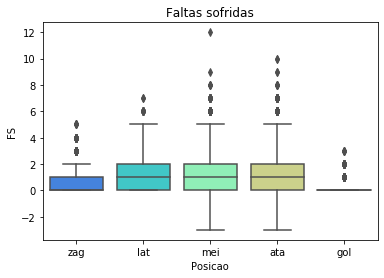

In [252]:
sns.boxplot(x="Posicao", y="FS", data=data,palette='rainbow').set_title('Faltas sofridas')

De acordo com o bloxplot gerado acima, as posições de goleiro e zagueiro sofrem menos faltas que as de lateral, meia e atacante. Entre essas posições, não há uma que se destaque neste quesito.

Então, verificou-se se existe alguma posição que possui maior tendência a cometer faltas:

Text(0.5, 1.0, 'Faltas cometidas')

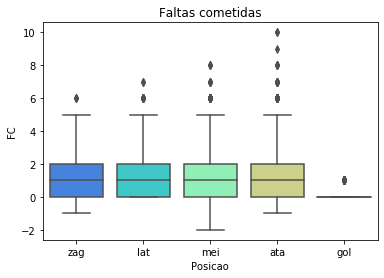

In [253]:
sns.boxplot(x="Posicao", y="FC", data=data,palette='rainbow').set_title('Faltas cometidas')

Novamente, de acordo com o bloxplot gerado acima, a posição de goleiro comete menos faltas que as restantes. Dentre elas,todas tendem a cometer o mesmo número de faltas. 

Com a finalidade de verificar qual posição tem maior tendência a levar cartões amarelos, aplicou-se uma máscara:

In [245]:
mask1 = data["CA"] ==1
ca1=data[mask1]
ca1

,A,Apelido,AtletaID,CA,CV,ClubeID,DD,DP,FC,FD,...,Posicao,RB,Rodada,SG,ano,away.score.x,dia,home.score.x,mes,variable
0,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,...,zag,0.0,1,1.0,2014,0.0,19.0,1.0,4.0,home.team
2,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,...,zag,1.0,3,0.0,2014,1.0,4.0,2.0,5.0,home.team
4,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,5.0,0.0,...,zag,0.0,5,1.0,2014,0.0,18.0,0.0,5.0,away.team
10,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,3.0,0.0,...,zag,1.0,12,1.0,2014,1.0,26.0,0.0,7.0,away.team
19,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,1.0,0.0,...,zag,0.0,26,0.0,2014,1.0,4.0,2.0,10.0,away.team
23,0.0,Juan,36540,1.0,0.0,Flamengo,0.0,0.0,1.0,0.0,...,zag,0.0,3,0.0,2016,2.0,25.0,2.0,5.0,home.team
28,0.0,Juan,36540,1.0,0.0,Flamengo,0.0,0.0,1.0,0.0,...,zag,0.0,38,1.0,2016,0.0,11.0,0.0,12.0,away.team
29,0.0,Juan,36540,1.0,0.0,Flamengo,0.0,0.0,2.0,1.0,...,zag,2.0,4,1.0,2017,0.0,4.0,0.0,6.0,home.team
30,0.0,Juan,36540,1.0,0.0,Flamengo,0.0,0.0,0.0,1.0,...,zag,2.0,5,0.0,2017,0.0,7.0,2.0,6.0,away.team
33,0.0,Juan,36540,1.0,0.0,Flamengo,0.0,0.0,1.0,0.0,...,zag,1.0,9,0.0,2017,1.0,22.0,5.0,6.0,home.team


In [246]:
ca1['Posicao'].value_counts()

mei    1183
ata     584
lat     552
zag     546
gol     120
Name: Posicao, dtype: int64

Text(0, 0.5, 'Número de cartões amarelos')

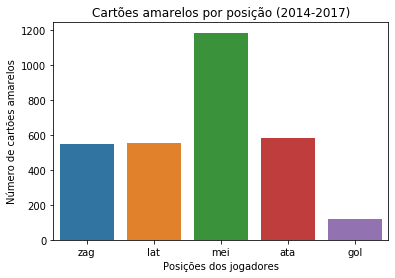

In [284]:
sns.countplot(x='Posicao',data=ca1).set_title('Cartões amarelos por posição (2014-2017)')
plt.xlabel("Posições dos jogadores")
plt.ylabel("Número de cartões amarelos")

Porém, deve-se considerar a proporção de jogadores em cada posição, inscritos no campeonato. Para verificar se há mais meias inscritos que atletas em outras posições, determinou-se a quantidade de atletas em cada posição:

In [273]:
data['Posicao'].value_counts()

mei    6516
ata    4050
lat    3045
zag    2628
gol    1328
Name: Posicao, dtype: int64

De fato, há mais meias e menos goleiros, comparado ao restante das posições. Tentou-se resolver este problema calculando a média de cartões por posição.

Assim, o dataframe foi agrupado por posição do jogador:

In [275]:
posicao=data.groupby(["Posicao"]).mean()

In [291]:
posicao.index

Index(['ata', 'gol', 'lat', 'mei', 'zag'], dtype='object', name='Posicao')

In [343]:
posicao

,A,AtletaID,CA,CV,DD,DP,FC,FD,FF,FS,...,PP,RB,Rodada,SG,ano,away.score.x,dia,home.score.x,mes,Posicao
Posicao,,,,,,,,,,,,,,,,,,,,,
ata,0.087160,70623.110370,0.143951,0.005679,0.00000,0.000000,1.261481,0.425679,0.554321,1.417531,...,0.007407,0.577778,19.535062,0.000000,2016.092840,1.006420,15.695802,1.404198,8.166667,ata
gol,0.003012,57625.685994,0.090361,0.003765,1.53012,0.033133,0.021837,0.000000,0.000000,0.201807,...,0.000000,0.007530,19.004518,0.306476,2015.908133,1.012048,15.905873,1.454066,8.048193,gol
lat,0.089655,67741.463711,0.181281,0.009524,0.00000,0.000000,1.263383,0.155008,0.235468,1.134975,...,0.003284,1.367159,20.264368,0.303777,2016.001642,0.962890,15.754680,1.403284,8.295238,lat
mei,0.069061,69973.149939,0.181093,0.009362,0.00000,0.000000,1.344997,0.262891,0.385820,1.258594,...,0.002762,1.321823,20.182167,0.001842,2016.079190,0.969920,15.728361,1.401013,8.282228,mei
zag,0.019026,67516.598554,0.207763,0.009513,0.00000,0.000000,0.999239,0.125571,0.238204,0.710426,...,0.000381,1.102740,20.210426,0.317732,2016.098554,0.977930,15.735540,1.414384,8.290335,zag


Notou-se que a coluna 'Posicao' se tornou index após a aplicação do método groupby. Não é possível plotar o gráfico utilizando o index como eixo x. Dessa forma, foi necessária a criação de uma coluna equivalente:

In [292]:
posicao['Posicao'] = posicao.index

Text(0, 0.5, 'Número médio de cartões amarelos')

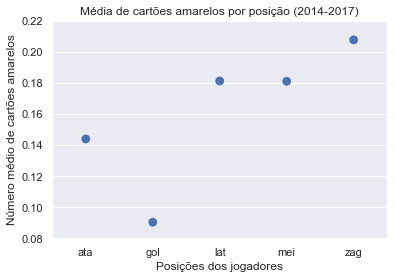

In [316]:
sns.pointplot(x="Posicao", y="CA", data=posicao,join=False, ci=68).set(ylim=(0.08, 0.22),
                                                                title='Média de cartões amarelos por posição (2014-2017)')
plt.xlabel("Posições dos jogadores")
plt.ylabel("Número médio de cartões amarelos")
#ci=68 para a barra de erro referente à média

Ao gerar os números médios de cartões amarelos referentes à cada posição, notou-se que, ao contrário do que foi visto na análise anterior, os zagueiros apresentam maior número de cartões médios neste intervalo de tempo. Essa discrepância evidencia a importância de trabalhar com dados balanceados de acordo com a amostragem.

Esse dataset "posicao" gerado traz muitas informações interessantes relativas às performances médias de cada posição de jogador em campo. Dentre elas, destacou-se:

Text(0, 0.5, 'Número médio de faltas cometidas')

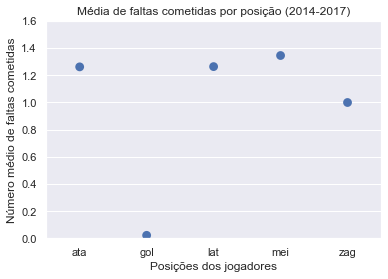

In [326]:
sns.pointplot(x="Posicao", y="FC", data=posicao,join=False, ci=68).set(ylim=(0.00, 1.6),
title='Média de faltas cometidas por posição (2014-2017)')
plt.xlabel("Posições dos jogadores")
plt.ylabel("Número médio de faltas cometidas")

Através do gráfico acima, pode-se inferir que a posição que mais comete faltas é de meia. Dentre os atletas de linha, os que menos cometem faltas são os zagueiros.

Text(0, 0.5, 'Número médio de faltas sofridas')

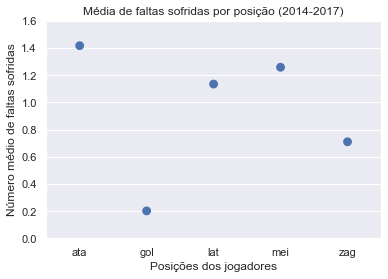

In [325]:
sns.pointplot(x="Posicao", y="FS", data=posicao,join=False, ci=68).set(ylim=(0.00, 1.6),
title='Média de faltas sofridas por posição (2014-2017)')
plt.xlabel("Posições dos jogadores")
plt.ylabel("Número médio de faltas sofridas")

No que se referem às faltas sofridas, dentre os atletas de linha, a posição que mais sofre é a de atacante, seguidas pelas de meia, lateral e zagueiro.

Text(0, 0.5, 'Número médio de passes errados')

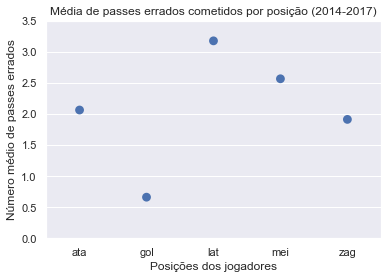

In [349]:
sns.pointplot(x="Posicao", y="PE", data=posicao,join=False, ci=68).set(ylim=(0.00, 3.5),
title='Média de passes errados cometidos por posição (2014-2017)')
plt.xlabel("Posições dos jogadores")
plt.ylabel("Número médio de passes errados")

Já sobre a posição que mais erra passes durante o jogo, pode-se perceber que é a de lateral. Possivelmente, porque é a posição que faz o maior número de cruzamentos e inversão de jogo. 

Text(0, 0.5, 'Número médio de gols feitos')

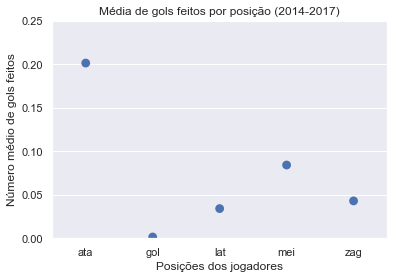

In [351]:
sns.pointplot(x="Posicao", y="G", data=posicao,join=False, ci=68).set(ylim=(0.00, 0.25),
title='Média de gols feitos por posição (2014-2017)')
plt.xlabel("Posições dos jogadores")
plt.ylabel("Número médio de gols feitos")

É importante ressaltar também que mesmo tratando os dados com base no número total de jogadores em cada posição (utilizando a média), algumas análises permanecem tendenciosas. É necessário ter cautela ao fazer uma análise em que o número de gols é um parâmetro para decidir o quão qualificado é o jogador, por exemplo. Isso porque atacantes têm uma maior média de gols feitos (como observado no gráfico acima), já que é se trata da atribuição principal de sua função. Do mesmo modo, apenas goleiros terão dados referentes à defesas difíceis, defesas difíceis e gols sofridos, como evidenciado abaixo:

In [353]:
posicao['DD'] #DD: defesas difíceis; apenas goleiros apresentam esse parâmetro

Posicao
ata    0.00000
gol    1.53012
lat    0.00000
mei    0.00000
zag    0.00000
Name: DD, dtype: float64

In [354]:
posicao['DP'] #DP: defesas de pênalti; apenas goleiros apresentam esse parâmetro

Posicao
ata    0.000000
gol    0.033133
lat    0.000000
mei    0.000000
zag    0.000000
Name: DP, dtype: float64

In [355]:
posicao['GS'] #GS: gols sofridos; apenas goleiros apresentam esse parâmetro

Posicao
ata    0.000000
gol    1.192771
lat    0.000000
mei    0.000000
zag    0.000000
Name: GS, dtype: float64

A fim de continuar a análise exploratória, determinou-se a correlação entre os pares do dataframe:

In [179]:
corr=data.corr()

In [180]:
corr

,A,AtletaID,CA,CV,DD,DP,FC,FD,FF,FS,...,PE,PP,RB,Rodada,SG,ano,away.score.x,dia,home.score.x,mes
A,1.000000,-0.012888,-0.001012,0.016308,-0.047791,-0.012015,0.041546,0.054915,0.050675,0.070613,...,0.084166,0.011819,0.030105,-0.003188,-0.026436,-0.013189,0.109758,-0.003166,0.120208,-0.000935
AtletaID,-0.012888,1.000000,-0.014142,-0.015765,-0.117572,-0.020552,0.029202,0.009843,0.016835,0.001042,...,-0.024859,-0.026175,0.049881,0.058792,-0.062498,0.251485,0.021521,-0.022084,-0.014722,0.055921
CA,-0.001012,-0.014142,1.000000,-0.022198,-0.038862,-0.007307,0.275372,0.003000,0.001535,0.059475,...,0.034901,-0.000031,0.050542,0.014779,-0.007699,0.010084,0.024945,-0.006925,-0.014080,0.014749
CV,0.016308,-0.015765,-0.022198,1.000000,-0.016556,-0.004409,0.066949,-0.016944,-0.003585,-0.004825,...,-0.004052,-0.005136,0.005607,0.003565,-0.020493,-0.004379,0.018949,-0.000211,0.004825,0.004495
DD,-0.047791,-0.117572,-0.038862,-0.016556,1.000000,0.144955,-0.189610,-0.093792,-0.112865,-0.143466,...,-0.171013,-0.011951,-0.168587,-0.010856,0.103441,-0.016409,0.004773,0.017444,0.007653,-0.014810
DP,-0.012015,-0.020552,-0.007307,-0.004409,0.144955,1.000000,-0.044209,-0.021955,-0.026420,-0.036651,...,-0.033757,-0.002798,-0.037970,0.006131,0.022105,0.004983,0.008843,0.002722,-0.001938,0.006252
FC,0.041546,0.029202,0.275372,0.066949,-0.189610,-0.044209,1.000000,0.074995,0.085627,0.182240,...,0.164722,0.000437,0.184918,0.002109,-0.074984,-0.022044,-0.001792,0.005988,-0.020822,0.002122
FD,0.054915,0.009843,0.003000,-0.016944,-0.093792,-0.021955,0.074995,1.000000,0.155272,0.125394,...,0.119581,0.051672,0.000478,0.010309,-0.098692,-0.011931,0.005200,0.014610,-0.007337,0.009012
FF,0.050675,0.016835,0.001535,-0.003585,-0.112865,-0.026420,0.085627,0.155272,1.000000,0.132628,...,0.119553,0.039806,0.030387,0.015028,-0.094319,-0.006515,-0.004768,0.010044,-0.017699,0.012952
FS,0.070613,0.001042,0.059475,-0.004825,-0.143466,-0.036651,0.182240,0.125394,0.132628,1.000000,...,0.217921,0.029966,0.145240,0.007253,-0.100998,-0.022040,-0.002777,0.010940,-0.011994,0.005349


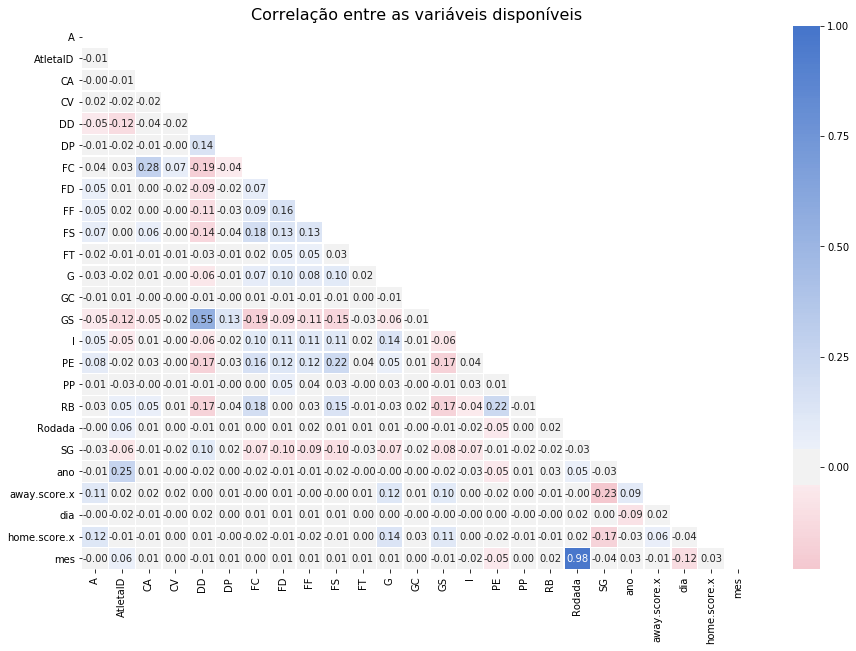

In [181]:
def correlation_matrix(corr, title=""):
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    plt.subplots(figsize=(15, 10))
    cmap = sns.diverging_palette(6, 255, as_cmap=True)
    
    chart = sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5, annot=True, fmt='.2f')
    plt.title(title, fontsize=16)
    
    return chart

corr_plot = correlation_matrix(corr, title='Correlação entre as variáveis disponíveis')

A partir da matriz de correlação gerada, pode-se inferir alguns aspectos:

- O maior valor absoluto de correlação é dado entre o par 'Rodada' e 'mês'. Isso ocorre porque a tabela do campeonato segue a mesma sequência todos os anos, ou seja, uma determinada rodada tende a ocorrer no mesmo mês nos anos seguintes.

Analisando apenas as correlações com valor correspondente acima de 0.15 em módulo (que se trata de um filtro determinado com base nos outros valores da matriz) entre variáveis numéricas, algumas observações podem ser realizadas. Dentre elas, destacou-se:

- O número de faltas cometidas se correlaciona positivamente com o número de cartões amarelos que o atleta recebeu. Isso pode estar associado ao fato que o cartão é das possíveis penalidades que o jogador pode receber ao cometer uma falta. Do mesmo modo, se correlaciona positivamente às faltas sofridas (se uma falta é cometida por um lado, o outro lado sofre a falta), aos passes errados e às roubadas de bola. Também se correlaciona negativamente às defesas difíceis e ao número de gols sofridos. 

- As defesas difíceis estão correlacionadas positivamente aos gols sofridos, possivelmente porque a mesma posição (goleiro) que faz uma defesa difícil também é aquela que sofre o gol.

- Roubadas de bola se correlacionam positivamente aos passes errados, possivelmente porque o time que erra os passes perde a posse da bola para o adversário. Os passes errados se correlacionam positivamente às faltas sofridas.

